## Import Library

In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pemisahan Dataset dan Augmentasi Data



In [3]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

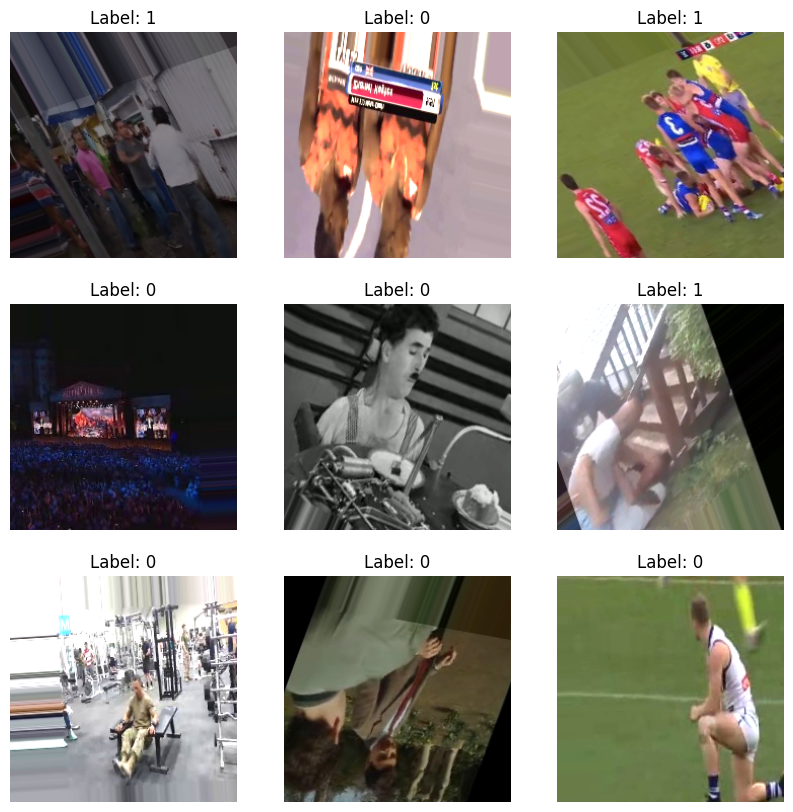

In [4]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [5]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 40
for layer in base_model.layers[:40]:
    layer.trainable = False
for layer in base_model.layers[40:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_Freeze40_0.01.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6605 - loss: 1.4255 
Epoch 1: val_accuracy improved from -inf to 0.57273, saving model to NoMCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 1040s 21s/step - accuracy: 0.6617 - loss: 1.4230 - val_accuracy: 0.5727 - val_loss: 1.3639
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7886 - loss: 1.0108
Epoch 2: val_accuracy improved from 0.57273 to 0.63636, saving model to NoMCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 656ms/step - accuracy: 0.7886 - loss: 1.0098 - val_accuracy: 0.6364 - val_loss: 1.0324
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7944 - loss: 0.8171
Epoch 3: val_accuracy did not improve from 0.63636
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 653ms/step - accuracy: 0.7945 - loss: 0.8166 - val_accuracy: 0.6341 - val_loss: 0.9825
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7779 - loss: 0.8091
Epoch 4: val_accuracy improved from 0.63636 to 0.72955, saving model to NoMCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 652ms/step - accuracy: 0.7782 - loss: 0.8077 - val_accuracy: 0.7295 - val_loss: 0.7646
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8174 - loss: 0.6764
Epoch 5: val_accuracy did not improve from 0.72955
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 633ms/step - accuracy: 0.8171 - loss: 0.6764 - val_accuracy: 0.7000 - val_loss: 0.9365
Epoch 6/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8150 - loss: 0.6570
Epoch 6: val_accuracy improved from 0.72955 to 0.83636, saving model to NoMCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 647ms/step - accuracy: 0.8145 - loss: 0.6577 - val_accuracy: 0.8364 - val_loss: 0.6048
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8121 - loss: 0.7278
Epoch 7: val_accuracy did not improve from 0.83636
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 637ms/step - accuracy: 0.8120 - loss: 0.7282 - val_accuracy: 0.7227 - val_loss: 0.9844
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8145 - loss: 0.8520
Epoch 8: val_accuracy did not improve from 0.83636
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 638ms/step - accuracy: 0.8143 - loss: 0.8517 - val_accuracy: 0.7705 - val_loss: 0.8289
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8026 - loss: 0.7810
Epoch 9: val_accuracy did not improve from 0.83636
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 644ms/step - accuracy: 0.8027 - loss: 0.7806 - val_accuracy: 0.8341 - val_loss: 0.6613
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8069 - loss: 0.7182
Epoch 10: val_accuracy did not

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.8271 - loss: 0.6888 - val_accuracy: 0.8409 - val_loss: 0.6316
Epoch 21/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8130 - loss: 0.6843
Epoch 21: val_accuracy did not improve from 0.84091
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 649ms/step - accuracy: 0.8133 - loss: 0.6831 - val_accuracy: 0.8159 - val_loss: 0.6404
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.8382 - loss: 0.6188
Epoch 22: val_accuracy did not improve from 0.84091
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 682ms/step - accuracy: 0.8380 - loss: 0.6193 - val_accuracy: 0.6773 - val_loss: 0.9514
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8117 - loss: 0.6554
Epoch 23: val_accuracy did not improve from 0.84091
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 657ms/step - accuracy: 0.8119 - loss: 0.6550 - val_accuracy: 0.8091 - val_loss: 0.5945
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8105 - loss: 0.6382
Epoch 24: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 654ms/step - accuracy: 0.8200 - loss: 0.5941 - val_accuracy: 0.8455 - val_loss: 0.6301
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8090 - loss: 0.6536
Epoch 27: val_accuracy did not improve from 0.84545
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.8090 - loss: 0.6541 - val_accuracy: 0.8114 - val_loss: 0.7421
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8005 - loss: 0.7440
Epoch 28: val_accuracy did not improve from 0.84545
49/49 ━━━━━━━━━━━━━━━━━━━━ 43s 699ms/step - accuracy: 0.8002 - loss: 0.7444 - val_accuracy: 0.7705 - val_loss: 0.8115
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8157 - loss: 0.7221
Epoch 29: val_accuracy did not improve from 0.84545
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 638ms/step - accuracy: 0.8155 - loss: 0.7218 - val_accuracy: 0.7909 - val_loss: 0.6794
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8281 - loss: 0.6516
Epoch 30: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 675ms/step - accuracy: 0.7867 - loss: 0.6977 - val_accuracy: 0.8523 - val_loss: 0.5990
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8138 - loss: 0.6494
Epoch 37: val_accuracy did not improve from 0.85227
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 650ms/step - accuracy: 0.8137 - loss: 0.6497 - val_accuracy: 0.7455 - val_loss: 0.7731
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8184 - loss: 0.6829
Epoch 38: val_accuracy did not improve from 0.85227
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 666ms/step - accuracy: 0.8183 - loss: 0.6827 - val_accuracy: 0.8432 - val_loss: 0.6260
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8414 - loss: 0.6314
Epoch 39: val_accuracy did not improve from 0.85227
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 682ms/step - accuracy: 0.8412 - loss: 0.6314 - val_accuracy: 0.6409 - val_loss: 1.0400
Epoch 40/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8236 - loss: 0.6459
Epoch 40: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 680ms/step - accuracy: 0.8039 - loss: 0.6398 - val_accuracy: 0.8545 - val_loss: 0.5111
Epoch 45/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7751 - loss: 0.8772
Epoch 45: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 661ms/step - accuracy: 0.7754 - loss: 0.8792 - val_accuracy: 0.5818 - val_loss: 1.6391
Epoch 46/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.7956 - loss: 0.9455
Epoch 46: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 653ms/step - accuracy: 0.7957 - loss: 0.9449 - val_accuracy: 0.8114 - val_loss: 0.8458
Epoch 47/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7883 - loss: 0.9227
Epoch 47: val_accuracy did not improve from 0.85455
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 655ms/step - accuracy: 0.7879 - loss: 0.9240 - val_accuracy: 0.8545 - val_loss: 0.9263
Epoch 48/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7765 - loss: 0.9994
Epoch 48: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 650ms/step - accuracy: 0.7918 - loss: 0.8960 - val_accuracy: 0.8568 - val_loss: 0.7602
Epoch 50/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7799 - loss: 0.8619
Epoch 50: val_accuracy did not improve from 0.85682
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 660ms/step - accuracy: 0.7805 - loss: 0.8606 - val_accuracy: 0.8068 - val_loss: 0.7991


## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.8911 - loss: 0.6121
Validation Loss: 0.7991306781768799
Validation Accuracy: 0.8068181872367859


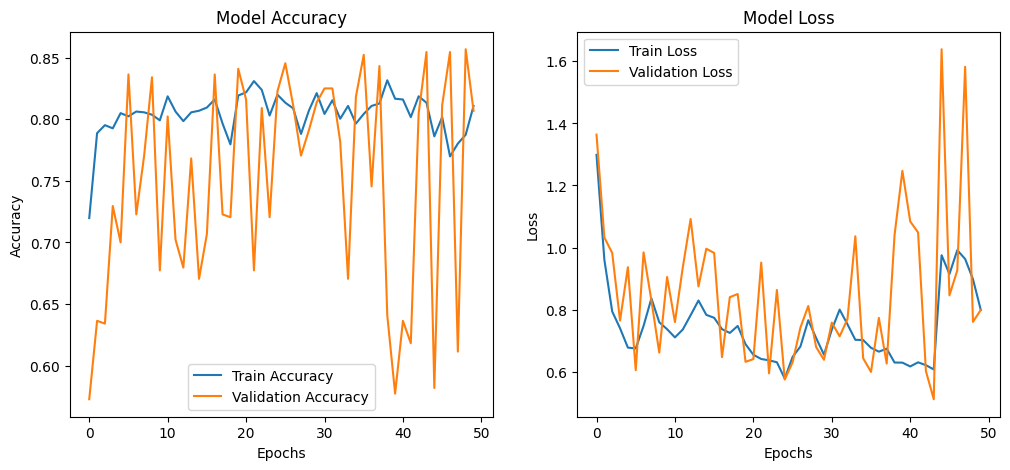

In [7]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [8]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_Freeze40_0.01.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 110s 18s/step - accuracy: 0.8488 - loss: 0.7280
Test Accuracy : 86.94%
Test Loss     : 0.708


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step


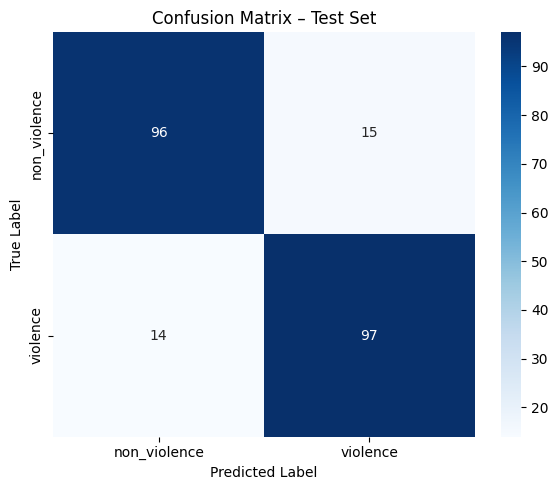


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.87      0.86      0.87       111
    violence       0.87      0.87      0.87       111

    accuracy                           0.87       222
   macro avg       0.87      0.87      0.87       222
weighted avg       0.87      0.87      0.87       222



In [9]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))